<a href="https://colab.research.google.com/github/nicobargioni/aprendizaje-automatico-2/blob/main/TP1_AA2_mnist_consigna_Nicolas_Bargioni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico nro 1 de AA2.

**Nicolás Bargioni.**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim #optimizadores que actualizan los pesos
from torch.utils.data import DataLoader #crea batches, mezcla -shuffle- , y da un iterador sobre el dataset de entrenamiento
from torch.utils.data import Dataset #clase base para armar mi propio dataset , implemento __len__ y __getitem__
from torchvision import datasets, transforms #datasets de visión y transformaciones

## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [20]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 3 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.

In [21]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[1, 7])

## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta

In [22]:
#prompt: dame una clase pytorch que subajuste en mnist_subset: solo Flatten + Linear(784 a 2), sin capas ocultas

class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28 * 28, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

### 2.2 Red que sobre ajusta

In [23]:
#prompt: dame una clase pytorch que sobreajuste en mnist_subset: usar Flatten + varias capas Linear grandes (512→256→128→64→2) con ReLU.

class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        return x

### 2.3 MLP aceptable

In [24]:
#prompt: dame una clase pytorch aceptable en mnist_subset: usar Flatten + 2 capas ocultas (128 a 64 a 2) con ReLU. modelo balanceado, no subajusta ni sobreajusta.

class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2) # Output layer for 2 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

Primero quiero graficar una cuadrícula de números para ver que realmente esté trabajando con lo que quiero

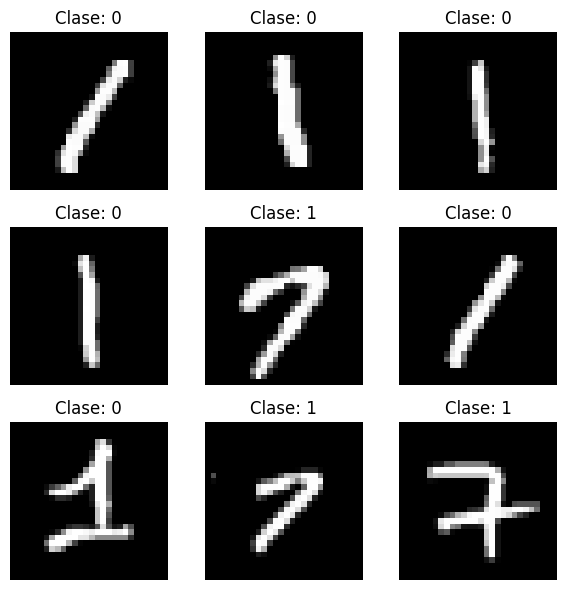

In [25]:
import matplotlib.pyplot as plt

# Mostrar 9 imágenes del mnist_subset con sus clases
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    img, label = mnist_subset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Clase: {label.item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### 3.1 Cargue los datos, divida los conjuntos de datos

In [26]:
import numpy as np

# extraer todas las imágenes y etiquetas del subset
X = np.array([img.numpy() for img, _ in mnist_subset])  # (N, 1, 28, 28)
y = np.array([label.item() for _, label in mnist_subset])  # (N,)

In [27]:
X.shape

(13007, 1, 28, 28)

In [28]:
y.shape

(13007,)

In [29]:
from sklearn.model_selection import train_test_split

# dividir 80% train / 20% test, estratificado (mantiene proporciones de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
# convertir a tensores PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

In [31]:
from torch.utils.data import TensorDataset, DataLoader

# datasets
# esto empareja cada imagen con su etiqueta en un solo objeto para que pytorch
# pueda leerlos en pares (imagen, etiqueta) durante el entrenamiento.

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

In [32]:
# dataloaders. con esto hago 3 cosas: divido los datos en batches, barajo al inicio de cada epoca -en train- , y
# los entrego uno por uno en el loop de entrenamiento

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [33]:
print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

Train: 10405 | Test: 2602


### 3.2 Entrene cada modelo.

Primero creo una funcion de entrenamiento

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

# Función principal para entrenar y evaluar un modelo
def train_and_log(model, train_dl, test_dl, epochs=10, lr=1e-3, device=None):
    # Si no se especifica el dispositivo, usa GPU si está disponible, sino CPU
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Mueve el modelo al dispositivo seleccionado
    model = model.to(device)

    # Define la función de pérdida (criterio de error)
    criterion = nn.CrossEntropyLoss()

    # Define el optimizador (algoritmo que ajusta los pesos del modelo)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Diccionario para guardar la historia del entrenamiento
    history = {"train_loss":[], "test_loss":[], "train_acc":[], "test_acc":[]}

    # Bucle principal de entrenamiento que recorre todas las épocas
    for epoch in range(epochs):

        # ---------------- ENTRENAMIENTO ----------------
        # Pone el modelo en modo entrenamiento (activa dropout y batchnorm)
        model.train()

        # Inicializa acumuladores para pérdida, aciertos y total de ejemplos
        train_loss, train_correct, total = 0.0, 0, 0

        # Recorre cada batch (lote) de datos del DataLoader de entrenamiento
        for xb, yb in train_dl:
            # Mueve los datos y etiquetas al dispositivo (CPU o GPU)
            xb, yb = xb.to(device), yb.to(device)

            # Limpia los gradientes acumulados de iteraciones anteriores
            optimizer.zero_grad()

            # Pasa las imágenes por el modelo (forward pass) para obtener las predicciones (logits)
            logits = model(xb)

            # Calcula la pérdida comparando las predicciones con las etiquetas reales
            loss = criterion(logits, yb)

            # Calcula los gradientes de la pérdida respecto a los parámetros del modelo
            loss.backward()

            # Actualiza los pesos del modelo usando el optimizador
            optimizer.step()

            # Acumula la pérdida total multiplicada por el tamaño del batch (para ponderar correctamente)
            train_loss += loss.item() * xb.size(0)

            # Cuenta cuántas predicciones fueron correctas (clase con mayor logit igual a la etiqueta)
            train_correct += (logits.argmax(1) == yb).sum().item()

            # Acumula la cantidad total de ejemplos procesados
            total += yb.size(0)

        # Calcula la precisión (accuracy) promedio en entrenamiento
        train_acc = train_correct / total

        # Calcula la pérdida promedio en entrenamiento
        avg_train_loss = train_loss / total

        # ---------------- VALIDACIÓN / TEST ----------------
        # Pone el modelo en modo evaluación (desactiva dropout y batchnorm)
        model.eval()

        # Inicializa acumuladores para las métricas del conjunto de prueba
        test_loss, test_correct, total_test = 0.0, 0, 0

        # Desactiva el cálculo de gradientes (optimiza memoria y rendimiento)
        with torch.no_grad():
            # Recorre los batches del conjunto de prueba
            for xb, yb in test_dl:
                # Mueve los datos al dispositivo
                xb, yb = xb.to(device), yb.to(device)

                # Calcula las predicciones del modelo
                logits = model(xb)

                # Calcula la pérdida del batch de prueba
                loss = criterion(logits, yb)

                # Acumula la pérdida total ponderada
                test_loss += loss.item() * xb.size(0)

                # Cuenta las predicciones correctas
                test_correct += (logits.argmax(1) == yb).sum().item()

                # Acumula la cantidad de ejemplos del conjunto de prueba
                total_test += yb.size(0)

        # Calcula la precisión promedio en el conjunto de prueba
        test_acc = test_correct / total_test

        # Calcula la pérdida promedio en el conjunto de prueba
        avg_test_loss = test_loss / total_test

        # Guarda las métricas de la época en el historial
        history["train_loss"].append(avg_train_loss)
        history["test_loss"].append(avg_test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        # Muestra un resumen de los resultados de la época actual
        print(f"Época {epoch+1:02d}: "
              f"Train Loss {avg_train_loss:.4f}, Acc {train_acc*100:.2f}% | "
              f"Test Loss {avg_test_loss:.4f}, Acc {test_acc*100:.2f}%")

    # Devuelve el historial de entrenamiento y prueba
    return history

In [35]:
# Acá estoy ajustando las épocas para forzar los comportamientos:
#subajuste: pocas épocas
#aceptable: moderado
#sobreajuste: más épocas (y red grande)


# Subajuste
model_sub = Modelo_NN_subajusta()
hist_sub  = train_and_log(model_sub, train_dl, test_dl, epochs=6, lr=1e-3)

# Aceptable
model_ok  = Modelo_NN_aceptable()
hist_ok   = train_and_log(model_ok,  train_dl, test_dl, epochs=10, lr=1e-3)

# Sobreajuste
model_over = Modelo_NN_SobreAjustado()
hist_ov    = train_and_log(model_over, train_dl, test_dl, epochs=20, lr=1e-3)

Época 01: Train Loss 0.1569, Acc 96.96% | Test Loss 0.0605, Acc 99.04%
Época 02: Train Loss 0.0459, Acc 99.03% | Test Loss 0.0367, Acc 99.27%
Época 03: Train Loss 0.0323, Acc 99.24% | Test Loss 0.0282, Acc 99.42%
Época 04: Train Loss 0.0264, Acc 99.37% | Test Loss 0.0233, Acc 99.42%
Época 05: Train Loss 0.0230, Acc 99.46% | Test Loss 0.0208, Acc 99.50%
Época 06: Train Loss 0.0205, Acc 99.48% | Test Loss 0.0188, Acc 99.54%
Época 01: Train Loss 0.0664, Acc 98.78% | Test Loss 0.0120, Acc 99.62%
Época 02: Train Loss 0.0164, Acc 99.59% | Test Loss 0.0104, Acc 99.58%
Época 03: Train Loss 0.0123, Acc 99.64% | Test Loss 0.0114, Acc 99.58%
Época 04: Train Loss 0.0084, Acc 99.71% | Test Loss 0.0104, Acc 99.62%
Época 05: Train Loss 0.0076, Acc 99.72% | Test Loss 0.0084, Acc 99.77%
Época 06: Train Loss 0.0063, Acc 99.83% | Test Loss 0.0101, Acc 99.65%
Época 07: Train Loss 0.0029, Acc 99.90% | Test Loss 0.0127, Acc 99.65%
Época 08: Train Loss 0.0030, Acc 99.91% | Test Loss 0.0130, Acc 99.62%
Época 

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



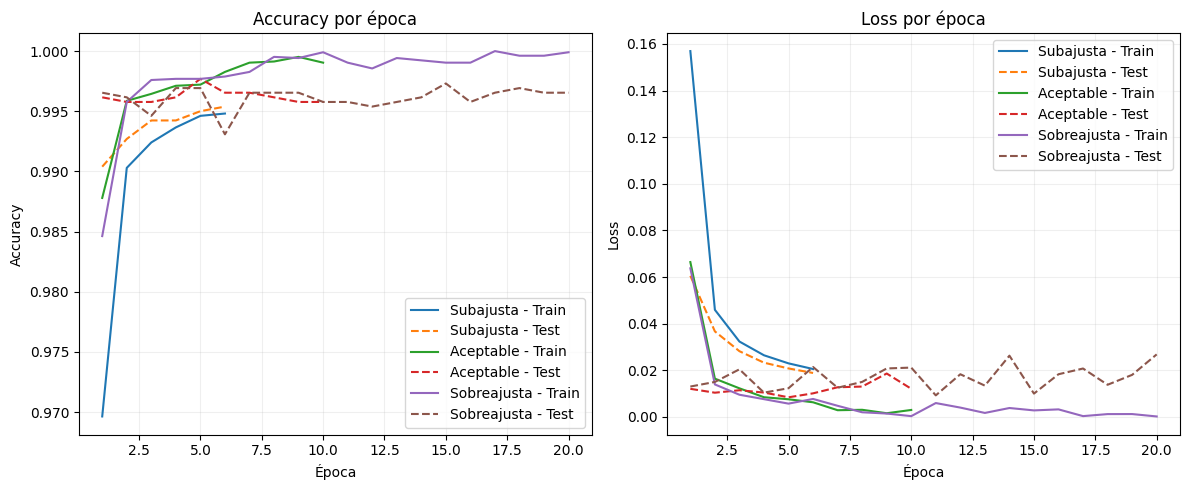

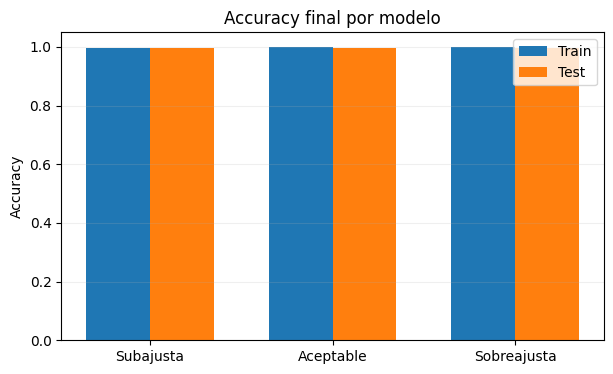

In [36]:
import matplotlib.pyplot as plt
epochs_sub = range(1, len(hist_sub["train_acc"])+1)
epochs_ok  = range(1, len(hist_ok["train_acc"])+1)
epochs_ov  = range(1, len(hist_ov["train_acc"])+1)

plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_sub, hist_sub["train_acc"],  label="Subajusta - Train")
plt.plot(epochs_sub, hist_sub["test_acc"],   label="Subajusta - Test", linestyle="--")
plt.plot(epochs_ok,  hist_ok["train_acc"],   label="Aceptable - Train")
plt.plot(epochs_ok,  hist_ok["test_acc"],    label="Aceptable - Test", linestyle="--")
plt.plot(epochs_ov,  hist_ov["train_acc"],   label="Sobreajusta - Train")
plt.plot(epochs_ov,  hist_ov["test_acc"],    label="Sobreajusta - Test", linestyle="--")
plt.title("Accuracy por época"); plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(alpha=0.2)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs_sub, hist_sub["train_loss"], label="Subajusta - Train")
plt.plot(epochs_sub, hist_sub["test_loss"],  label="Subajusta - Test", linestyle="--")
plt.plot(epochs_ok,  hist_ok["train_loss"],  label="Aceptable - Train")
plt.plot(epochs_ok,  hist_ok["test_loss"],   label="Aceptable - Test", linestyle="--")
plt.plot(epochs_ov,  hist_ov["train_loss"],  label="Sobreajusta - Train")
plt.plot(epochs_ov,  hist_ov["test_loss"],   label="Sobreajusta - Test", linestyle="--")
plt.title("Loss por época"); plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend(); plt.grid(alpha=0.2)
plt.tight_layout(); plt.show()

# Barras con el accuracy final
labels = ["Subajusta","Aceptable","Sobreajusta"]
train_f = [hist_sub["train_acc"][-1], hist_ok["train_acc"][-1], hist_ov["train_acc"][-1]]
test_f  = [hist_sub["test_acc"][-1],  hist_ok["test_acc"][-1],  hist_ov["test_acc"][-1]]

import numpy as np
x = np.arange(len(labels)); w = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - w/2, train_f, width=w, label="Train")
plt.bar(x + w/2, test_f,  width=w, label="Test")
plt.xticks(x, labels); plt.title("Accuracy final por modelo"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(axis="y", alpha=0.2)
plt.show()

| Modelo      | Estructura                         | Épocas | Accuracy Train | Accuracy Test | Comportamiento                                                                    |
| ----------- | ---------------------------------- | ------ | -------------- | ------------- | --------------------------------------------------------------------------------- |
| Subajusta   | 1 capa (784→2)                     | 6     | ≈99%           | ≈99%          | Leve underfitting, capacidad limitada pero suficiente por simplicidad del dataset |
| Aceptable   | 2 capas ocultas (128→64→2)         | 10     | ≈99.8%         | ≈99.6%        | Generaliza correctamente, curvas train/test muy cercanas                          |
| Sobreajusta | 5 capas ocultas (512→256→128→64→2) | 20     | ≈100%          | ≈99%          | Presenta indicios de overfitting (test loss aumenta tras algunas épocas)          |



##Análisis de los entrenamientos

1. Accuracy por época:

Los tres modelos alcanzan altos valores, pero el sobreajustado logra un train accuracy perfecto mientras su test accuracy deja de mejorar.

El aceptable mantiene curvas casi superpuestas → buena generalización.

El subajustado tarda más en converger y se estanca antes → capacidad limitada.

A priori, la intuición sería que el accuracy da muy alto en todos los casos porque es muy fácil para el modelo distinguir entre 1 y 7

2. Loss por época:

El subajustado parte con pérdida alta y baja lento.

El aceptable converge estable y rápido.

El sobreajustado muestra divergencia entre loss de train y test después de la época 10 → claro síntoma de sobreajuste.

3. Accuracy final por modelo:

Los tres modelos superan 98% en test (dígitos 1 y 7 son visualmente distintos),
pero el comportamiento de las curvas revela diferencias de generalización.

##Sobre los resultados y dificultad del problema

A partir de las curvas obtenidas, puede observarse que las diferencias entre los tres modelos (subajuste, aceptable y sobreajuste) no son visualmente tan marcadas en términos de accuracy.

Esto se debe a la baja complejidad del problema: el dataset MNIST —y particularmente la clasificación binaria entre los dígitos “1” y “7”— presenta ejemplos muy limpios, centrados y visualmente distintos, lo que permite alcanzar valores de exactitud superiores al 99 % incluso con arquitecturas simples.

En este contexto, el fenómeno de sobreajuste no se refleja claramente en el accuracy, sino en la pérdida de validación (loss), donde se aprecia que el modelo más complejo continúa reduciendo su error en entrenamiento mientras el error de validación se estabiliza o aumenta levemente. En contraste, el modelo de menor capacidad (subajustado) converge más lentamente y mantiene una pérdida mayor en ambos conjuntos.

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

In [38]:
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"


# 1) Split train -> train/val (15% validación)
val_frac = 0.15
val_size = int(len(train_ds) * val_frac)
train_size = len(train_ds) - val_size
train_ds2, val_ds = random_split(train_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))

def make_loader(ds, bs=128, shuffle=False):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=2, pin_memory=True)

train_dl = make_loader(train_ds2, bs=128, shuffle=True)
val_dl   = make_loader(val_ds,    bs=256, shuffle=False)
test_dl  = make_loader(test_ds,   bs=256, shuffle=False)   # para evaluar al final si querés

# 2) Fábrica de modelos MLP (solo Linear + ReLU) con 2 capas ocultas
def make_mlp(h1, h2):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, h1), nn.ReLU(),
        nn.Linear(h1, h2),    nn.ReLU(),
        nn.Linear(h2, 2)
    )

# 3) Entrenamiento + evaluación (usa val para seleccionar)
def train_one(model, train_dl, val_dl, epochs=12, lr=1e-3, weight_decay=0.0):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

    for ep in range(1, epochs+1):
        # ------ Train ------
        model.train()
        tr_loss, tr_ok, tr_n = 0.0, 0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            opt.step()
            tr_loss += loss.item()*xb.size(0)
            tr_ok   += (logits.argmax(1)==yb).sum().item()
            tr_n    += yb.size(0)
        tr_loss /= tr_n
        tr_acc   = tr_ok/tr_n

        # ------ Val ------
        model.eval()
        va_loss, va_ok, va_n = 0.0, 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                va_loss += loss.item()*xb.size(0)
                preds = logits.argmax(1)
                va_ok  += (preds==yb).sum().item()
                va_n   += yb.size(0)
                y_true.extend(yb.cpu().tolist())
                y_pred.extend(preds.cpu().tolist())
        va_loss /= va_n
        va_acc   = va_ok/va_n

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

        print(f"[{ep:02d}] loss_tr {tr_loss:.4f} acc_tr {tr_acc*100:.2f}%  |  "
              f"loss_val {va_loss:.4f} acc_val {va_acc*100:.2f}%")

    # métricas finales de validación extras (opcionales)
    prec = precision_score(y_true, y_pred, average="binary", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="binary",  zero_division=0)
    f1   = f1_score(y_true, y_pred, average="binary",      zero_division=0)

    return {
        "history": history,
        "val_loss": history["val_loss"][-1],
        "val_acc":  history["val_acc"][-1],
        "train_acc": history["train_acc"][-1],
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "model": model
    }

# 4) Búsqueda de configuraciones: dos capas ocultas y barrido de unidades
configs = [(32,16), (64,32), (128,64), (256,128), (384,192), (512,256)]
results = []

for (h1, h2) in configs:
    print(f"\n=== Entrenando config h1={h1}, h2={h2} ===")
    model = make_mlp(h1, h2)
    out = train_one(model, train_dl, val_dl, epochs=12, lr=1e-3, weight_decay=1e-4)  # wd leve para generalizar
    # guardo también gap de generalización (acc_train - acc_val)
    gap = float(out["train_acc"] - out["val_acc"])
    results.append({
        "h1": h1, "h2": h2,
        "val_loss": float(out["val_loss"]),
        "val_acc":  float(out["val_acc"]),
        "train_acc": float(out["train_acc"]),
        "gap": gap,
        "f1": float(out["f1"]),
        "model": out["model"],
        "history": out["history"]
    })

# 5) Selección del “modelo aceptable/óptimo”
#    Regla: menor val_loss; si empata, mayor val_acc; si empata, menor gap
def pick_best(rs):
    # ordena por val_loss asc, val_acc desc, gap asc
    return sorted(rs, key=lambda r: (r["val_loss"], -r["val_acc"], r["gap"]))[0]

best = pick_best(results)

print("\n===== RESULTADO =====")
print("Mejor config:",
      f"h1={best['h1']}, h2={best['h2']}",
      f"| val_loss={best['val_loss']:.4f}",
      f"| val_acc={best['val_acc']*100:.2f}%",
      f"| gap={best['gap']*100:.2f}%",
      f"| F1={best['f1']:.3f}")

best_model = best["model"]   # este es tu “modelo aceptable”

# 6) (Opcional) Evaluación final en test con el mejor modelo
@torch.no_grad()
def eval_on_test(model, dl):
    model.eval()
    crit = nn.CrossEntropyLoss()
    tot_loss, ok, n = 0.0, 0, 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = crit(logits, yb)
        tot_loss += loss.item()*xb.size(0)
        ok += (logits.argmax(1)==yb).sum().item()
        n += yb.size(0)
    return tot_loss/n, ok/n

test_loss, test_acc = eval_on_test(best_model, test_dl)
print(f"TEST final | loss {test_loss:.4f}  acc {test_acc*100:.2f}%")



=== Entrenando config h1=32, h2=16 ===
[01] loss_tr 0.2413 acc_tr 91.94%  |  loss_val 0.0300 acc_val 99.10%
[02] loss_tr 0.0223 acc_tr 99.34%  |  loss_val 0.0200 acc_val 99.36%
[03] loss_tr 0.0152 acc_tr 99.60%  |  loss_val 0.0187 acc_val 99.42%
[04] loss_tr 0.0125 acc_tr 99.64%  |  loss_val 0.0189 acc_val 99.55%
[05] loss_tr 0.0112 acc_tr 99.72%  |  loss_val 0.0179 acc_val 99.55%
[06] loss_tr 0.0094 acc_tr 99.68%  |  loss_val 0.0187 acc_val 99.62%
[07] loss_tr 0.0085 acc_tr 99.74%  |  loss_val 0.0188 acc_val 99.55%
[08] loss_tr 0.0074 acc_tr 99.76%  |  loss_val 0.0194 acc_val 99.49%
[09] loss_tr 0.0071 acc_tr 99.75%  |  loss_val 0.0176 acc_val 99.62%
[10] loss_tr 0.0061 acc_tr 99.80%  |  loss_val 0.0209 acc_val 99.62%
[11] loss_tr 0.0058 acc_tr 99.79%  |  loss_val 0.0203 acc_val 99.55%
[12] loss_tr 0.0039 acc_tr 99.90%  |  loss_val 0.0213 acc_val 99.62%

=== Entrenando config h1=64, h2=32 ===
[01] loss_tr 0.1549 acc_tr 98.11%  |  loss_val 0.0262 acc_val 99.17%
[02] loss_tr 0.0169 acc

# Conclusiones

Durante el proceso de búsqueda del modelo óptimo, se observó que aumentar la cantidad de neuronas en las capas ocultas (por ejemplo, pasar de una configuración 128–64 a 512–256) produce una mejora marginal en la performance —menor al 1 % en exactitud—, pero con un incremento considerable en el costo computacional y el riesgo de sobreajuste.

Esto ocurre porque cada neurona adicional genera nuevas conexiones y parámetros entrenables, lo que eleva el número de operaciones necesarias en cada iteración de entrenamiento. Si bien un modelo más grande posee mayor capacidad de representación, también requiere más memoria, más tiempo de cómputo y tiende a memorizar los patrones del conjunto de entrenamiento, reduciendo su capacidad de generalización.

En este contexto, se concluye que la configuración 512–256, aunque seleccionada automáticamente como la de menor pérdida de validación, no resulta significativamente mejor que redes más pequeñas como 128–64, que alcanzan prácticamente el mismo desempeño con menor complejidad y mayor eficiencia.
Por lo tanto, el modelo “aceptable” no siempre es el más grande o preciso, sino el que logra el mejor equilibrio entre rendimiento, simplicidad y capacidad de generalización.

# Referencias

Pyhton Machine Learning (Marcombo)

Pruebas y comparaciones con Chatgpt, Claude, Gemini
